# HoVerNet Post Processing 

In [1]:
%matplotlib widget

In [2]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

# Output of Model
Here, I visualize what the output of the model is.

In [3]:
# MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet

checkpoint_path = os.path.join(parent,"model","HoVerNet_C.ckpt")
args = {"RESNET_SIZE":50, "START_LR":0,}
model = HoVerNet.load_from_checkpoint(checkpoint_path,categories=True,**args)

In [4]:
# TRANSFORMS
from torchvision.transforms import Compose,RandomApply
from src.transforms.image_processing.augmentation import *


scale_modes = {"image": InterpolationMode.BILINEAR, "semantic_mask": InterpolationMode.NEAREST, "instance_mask": InterpolationMode.NEAREST,"categorical_mask":InterpolationMode.NEAREST}
transforms = Compose([


        RandomCrop(size=(128, 128)),

        ]) 

norm =         Normalize(
                {"image": [0.6441, 0.4474, 0.6039]},
                {"image": [0.1892, 0.1922, 0.1535]})

In [5]:
# DATA

from src.datasets.PanNuke import PanNuke

folder=  os.path.join(parent,"data","processed","PanNuke")
dataset_val = PanNuke(folder,transform=transforms)

In [6]:
# SAMPLE
from tqdm import tqdm
sample = [dataset_val[i] for i in tqdm(range(5))]

100%|██████████| 5/5 [00:00<00:00, 78.12it/s]


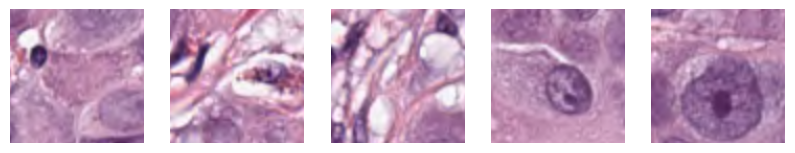

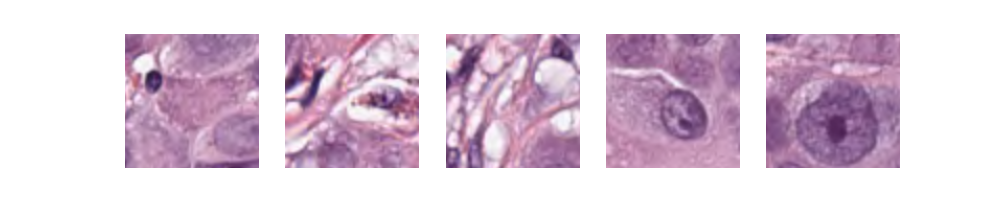

In [7]:
from src.utilities.img_utilities import tensor_to_numpy,numpy_to_tensor
from src.vizualizations.image_viz import plot_images
images = [tensor_to_numpy(img['image']) for img in sample]
plot_images(images,(1,5))

In [8]:
# PREDICTIONS

model.eval()
model.cpu()
predictions = []
for item in tqdm(sample,total = len(sample)):
    sm,hv,c = model(norm(item)["image"].unsqueeze(0))
    sm = sm.squeeze().detach().cpu()
    hv = hv.squeeze().detach().cpu()
    predictions.append({"semantic_mask":sm,"hover_map":hv,"semantic_mask_hard":(sm>0.5).int(),"category":c})


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


In [9]:
print(predictions[0]["category"])

tensor([[[[0.2761, 0.3548, 0.3734,  ..., 0.0476, 0.0508, 0.0638],
          [0.3489, 0.4146, 0.4430,  ..., 0.0410, 0.0391, 0.0523],
          [0.3864, 0.4659, 0.4853,  ..., 0.0399, 0.0367, 0.0447],
          ...,
          [0.2638, 0.2835, 0.2296,  ..., 0.7094, 0.6532, 0.5200],
          [0.2276, 0.2582, 0.2128,  ..., 0.6587, 0.6030, 0.4797],
          [0.1740, 0.2022, 0.1732,  ..., 0.5345, 0.4859, 0.3707]],

         [[0.0286, 0.0226, 0.0157,  ..., 0.0049, 0.0070, 0.0107],
          [0.0248, 0.0161, 0.0105,  ..., 0.0030, 0.0039, 0.0069],
          [0.0186, 0.0117, 0.0065,  ..., 0.0025, 0.0032, 0.0050],
          ...,
          [0.0486, 0.0383, 0.0237,  ..., 0.0041, 0.0081, 0.0143],
          [0.0451, 0.0420, 0.0270,  ..., 0.0075, 0.0142, 0.0218],
          [0.0387, 0.0402, 0.0282,  ..., 0.0129, 0.0226, 0.0274]],

         [[0.0697, 0.0628, 0.0567,  ..., 0.0129, 0.0163, 0.0231],
          [0.0742, 0.0622, 0.0561,  ..., 0.0097, 0.0109, 0.0168],
          [0.0703, 0.0617, 0.0511,  ..., 0

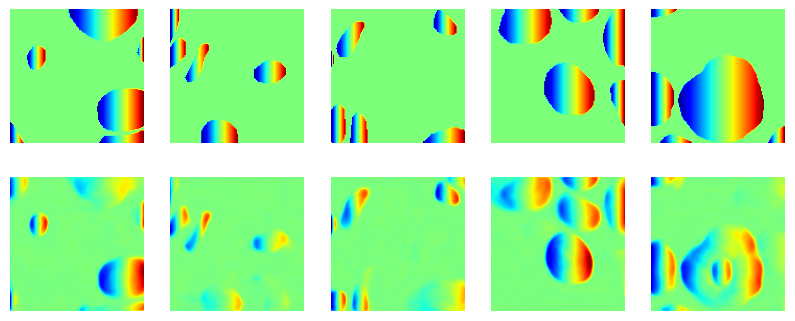

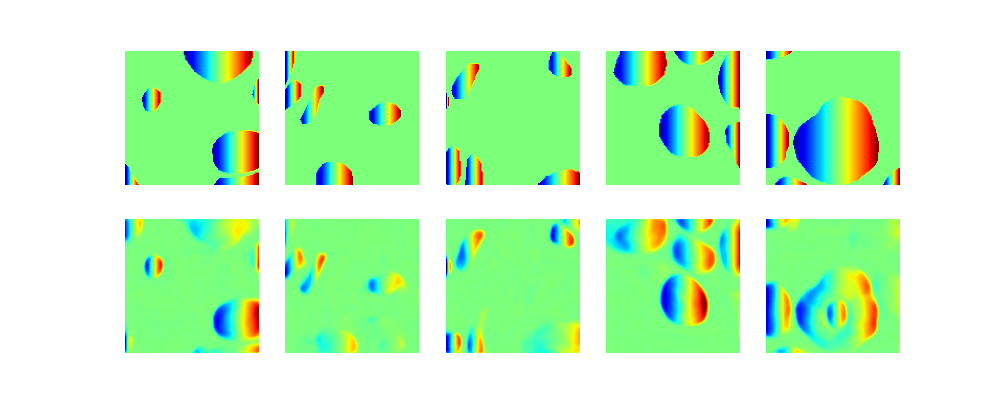

In [10]:
# DISPLAY


h_maps = [img["hover_map"][0] for img in sample] + [img["hover_map"][0] for img in predictions]
plot_images(h_maps,(2,5),"jet",vmin=-1,vmax=1)

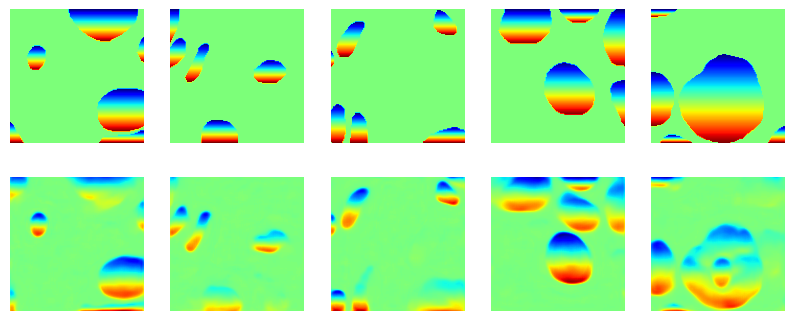

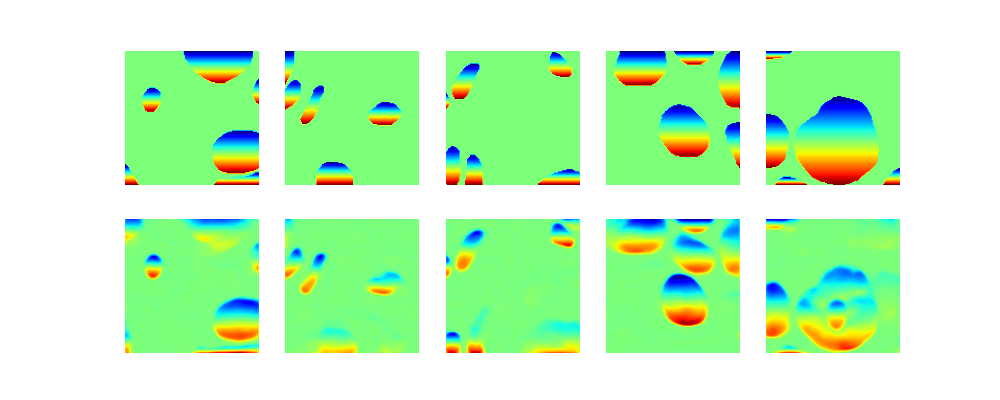

In [11]:
v_maps = [img["hover_map"][1] for img in sample] + [img["hover_map"][1] for img in predictions]
plot_images(v_maps,(2,5),"jet", vmin=-1,vmax=1)

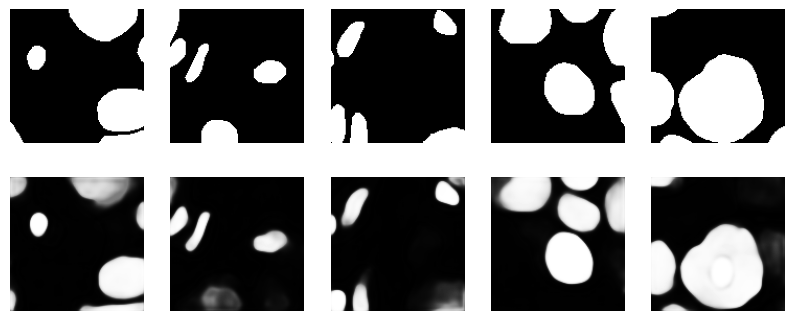

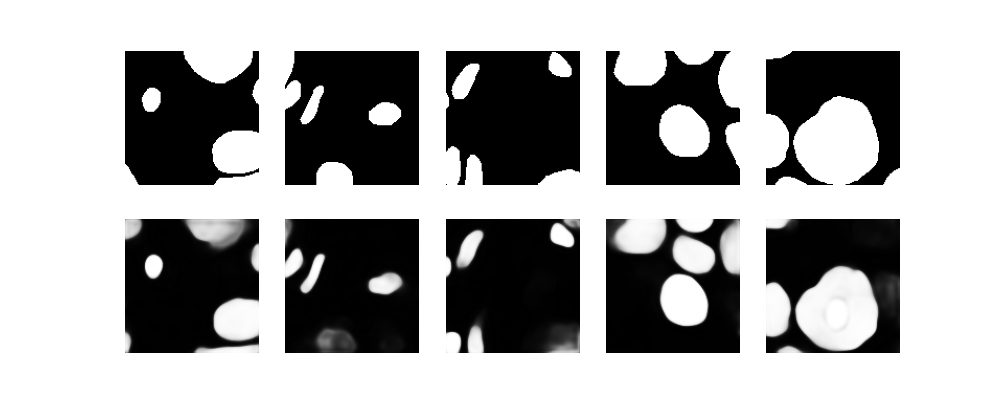

In [12]:
sms = [img["semantic_mask"].squeeze() for img in sample] +[img["semantic_mask"] for img in predictions]
plot_images(sms,(2,5),"gray")

# Filters
Here, I explore some image processing filters, such as the Sobel Filter for edge detection.

In [13]:
from PIL import ImageFilter
from torchvision.transforms import ToPILImage
from torch.nn.functional import conv2d
from torch import Tensor
import cv2

sobel_x = Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).unsqueeze(0).unsqueeze(0).float()/4
sobel_y = Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).unsqueeze(0).unsqueeze(0).float()/4

def sobel(img:Tensor):
    assert len(img.shape)==2
    
    img_np = img.numpy()
    img_normed = cv2.normalize(img_np,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
    sobel_x = cv2.Sobel(img_normed,cv2.CV_32F,1,0,ksize=11)
    sobel_y = cv2.Sobel(img_normed,cv2.CV_32F,0,1,ksize=11)
    sx_normed = cv2.normalize(sobel_x,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
    sy_normed = cv2.normalize(sobel_y,None,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
    return torch.as_tensor(sx_normed),torch.as_tensor(sy_normed)
    #img = img.unsqueeze(0).unsqueeze(0)
    #img_x = conv2d(img,sobel_x,stride=1,padding=1)
    #img_y = conv2d(img,sobel_y,stride=1,padding=1)
    #return img_x,img_y

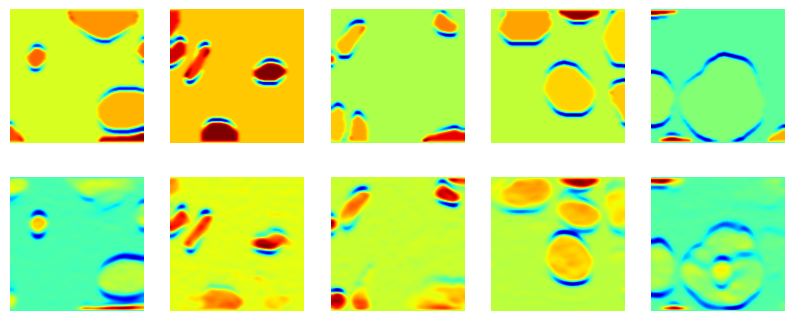

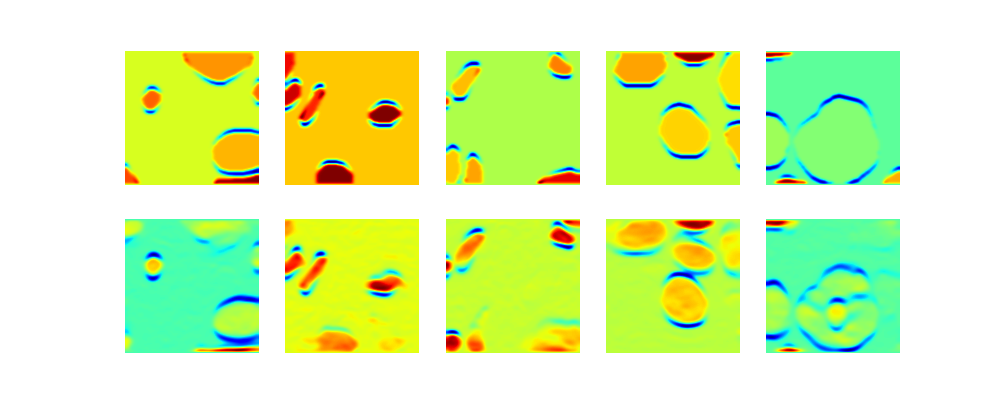

In [14]:
v_maps_sobel = [sobel(img.float().clip(-1,1)) for img in v_maps]
plot_images([img[1] for img in v_maps_sobel],(2,5),"jet",vmin=0,vmax=1)

# you can see cells are 0 in first and non zero in second. This because horizontal grad perp to vertical

In [15]:
def _S(hv_map:Tensor):
    hv_horiz,hv_vert = hv_map
    hpx = sobel(hv_horiz.float())[0].abs()
    hpy = sobel(hv_vert.float())[1].abs()
    return torch.maximum(1-hpx,1-hpy).squeeze()

By looking at the sobel operator on the hover maps, we can start to see outlines of overlapping cells. On the top are the ground truth hover maps and on the bottom are predicted hovermaps. There are some intersting artefacts on the cells, making them look like loaves of bread.

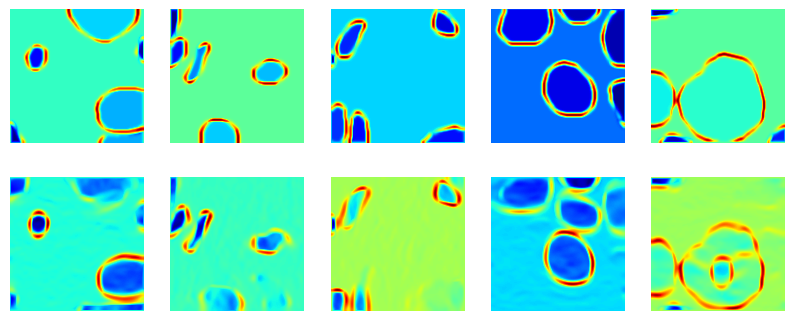

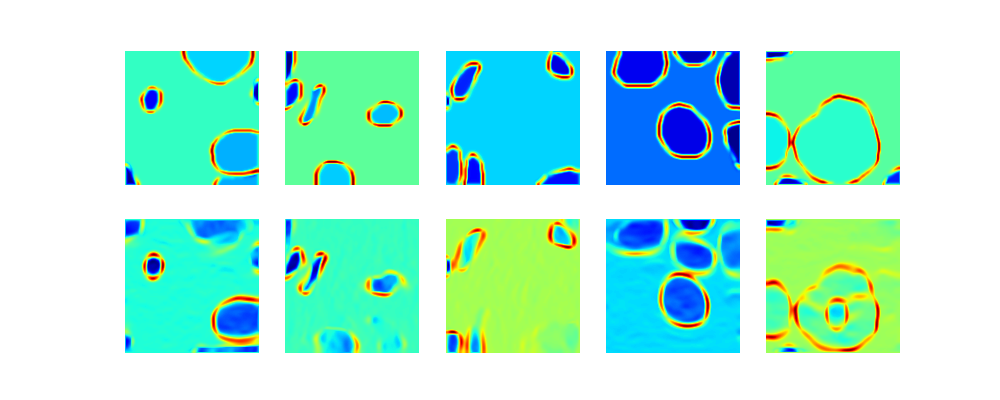

In [16]:
importance = [_S(img) for img in zip(h_maps,v_maps)]
plot_images(importance,(2,5),"jet")

In [17]:
# Hyper parameters
h = 0.5
k = 0.4

C:\Users\aless\AppData\Local\Temp\ipykernel_16764\2186937085.py:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


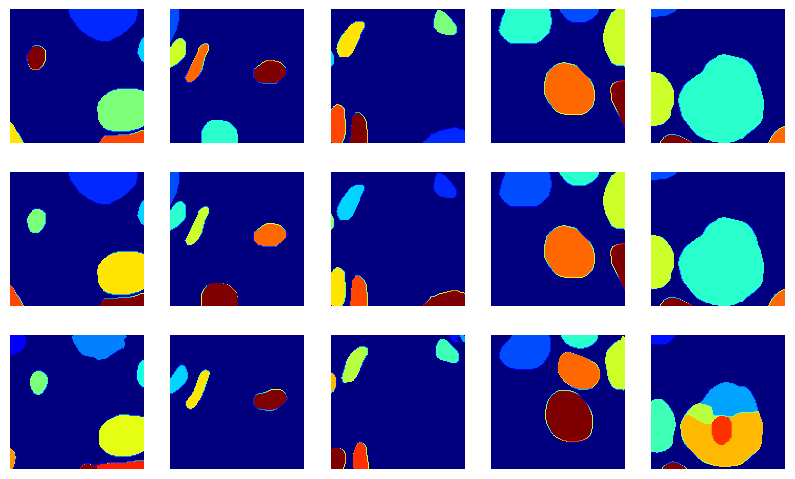

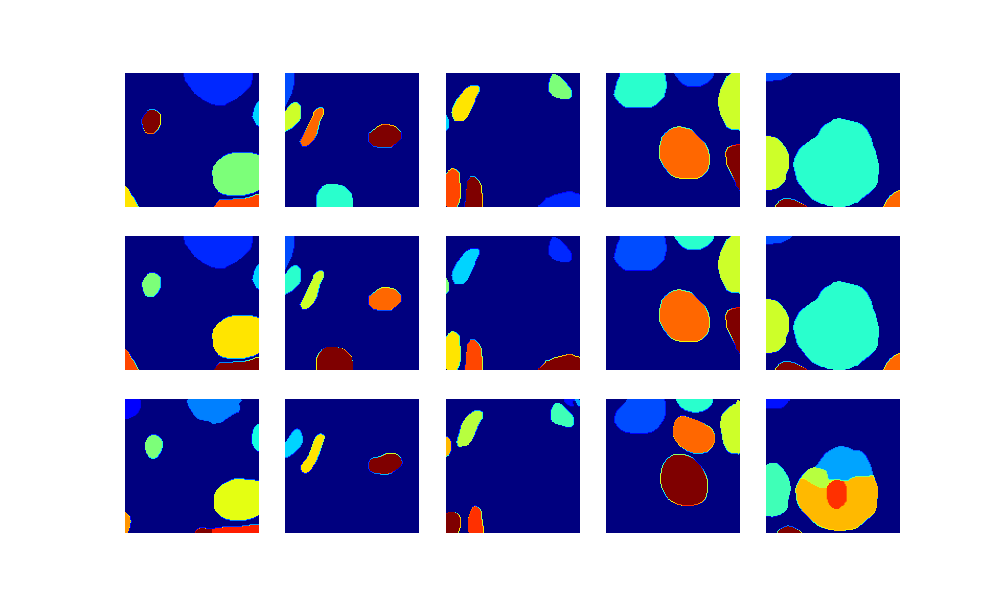

In [18]:

from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_fill_holes,binary_closing
from scipy.ndimage.measurements import label
from skimage.segmentation import watershed
from src.utilities.tensor_utilties import reset_ids

def post_processing_pipeline(sm:Tensor,hv_map:Tensor,h=0.5,k=0.5,smooth_amt = 7): #todo doc and annotate
    Sm = _S(hv_map)
    thresh_q = (sm > h)
    thresh_q = torch.as_tensor(remove_small_objects(thresh_q.numpy(), min_size=30))
    Sm = (Sm - (1-thresh_q.float())).clip(0)  # importance regions with background haze removed via mask with clipping

    # to get areas of low importance (i.e. centre of cells) as high energy and areas close to border are low energy
    energy = (1-Sm)*thresh_q
    # also clip again background
    energy = torch.as_tensor(cv2.GaussianBlur(energy.numpy(), (smooth_amt, smooth_amt), 0)
                             )  # smooth landscape # especially important for long cells

    markers = (thresh_q.float() - (Sm > k).float())
    markers = label(markers)[0]
    # Slightly different to paper - I use the energy levels instead because they have been smoothed
    markersv2 = (energy > k).numpy()
    markersv2 = binary_fill_holes(markersv2)
    markersv2 = label(markersv2)[0]
    return torch.as_tensor(watershed(-energy.numpy(), markers=markersv2, mask=thresh_q.numpy()), dtype=torch.int)


ins_gt = [reset_ids(img["instance_mask"].squeeze().numpy()) for img in sample]
ins_pred = [post_processing_pipeline(sm,hv_map,k=0.5,smooth_amt=5) for sm,hv_map in zip(sms,zip(h_maps,v_maps))]
plot_images(ins_gt+ins_pred,(3,5),"jet")

As you can see, what is important is that the GT Semantic Mask and Hover Maps produce perfect segmentation, which they do above!

# Cell Type Prediction

dict_keys(['image', 'instance_mask', 'semantic_mask', 'category_mask', 'image_original', 'hover_map'])
torch.Size([128, 128])


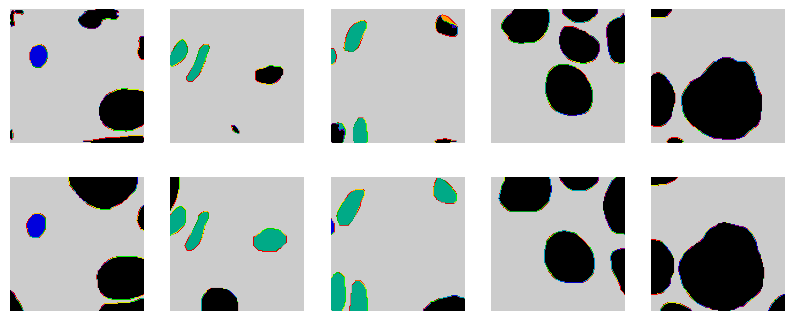

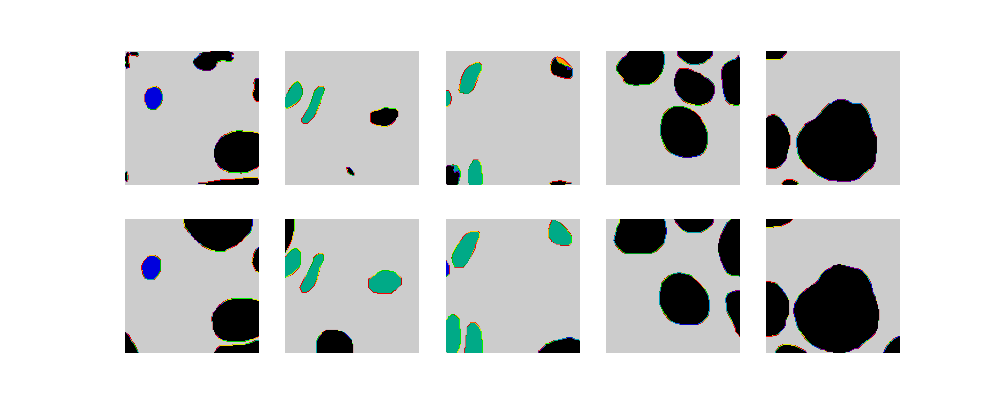

In [19]:
print(sample[0].keys())
cat_examples = [img['category'].argmax(dim=1).squeeze() for img in predictions]+[img['category_mask'].argmax(dim=0) for img in sample]
print(cat_examples[0].shape)
plot_images(cat_examples,(2,5))

In [29]:
from src.transforms.graph_construction.hovernet_post_processing import assign_instance_class_label

ins_1 =  ins_pred[0+5]
ins_gt_1 = torch.as_tensor(ins_gt[0])
np_1 = predictions[0]['category'].squeeze()
np_gt_1 = sample[0]['category_mask'].squeeze()
img_1 = images[0].squeeze()

cell_pred_1 = assign_instance_class_label(ins_1,np_1)
cell_gt_1 = assign_instance_class_label(ins_gt_1,np_gt_1)

# Vizualized

In [70]:
from numpy.ma import masked_where
from src.transforms.graph_construction.percolation import hollow
import numpy as np

def create_coloured_mask(mask:np.ndarray,colour):
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask,axis=2).repeat(3,axis=2)  # introduce new axis and then fill with repeat
    colour = np.asarray(colour)
    coloured_mask = np.zeros_like(mask)+colour
    return coloured_mask*mask

def instance_segmentation_vizualised(img, instance_seg, cat_pred:np.ndarray, figsize=(20, 20)):
    """Plots image and the segmentation overlayed on top

    Args:
        img (Tensor): Original Image (3,H,W)
        instance_seg (Tensor): Instance Segmentation of Image (same size) (H,W)
        cat_pred (np.ndarray): List of cell type predictions. cat_pred[i] is cell i's prediction
    """
    assert img.shape[1:] == instance_seg.shape[:], "Image and instance segmentation must be same size"

    colour_scheme = [[1.,0.,0.],[1.0,0.5,0.],[0.,1.,0.],[0.,0.,1.],[1.0,1.0,0.]] # neo - red, non-neo - orange, inflam - green, conn - blue, dead - yell
    hl = tensor_to_numpy(hollow(instance_seg))
    
    
    hollow_masks = [np.isin(hl,np.nonzero(cat_pred==cell_type)) for cell_type in range(0,5)]
    masks = [create_coloured_mask(hm,colour) for i,colour,hm in zip(range(5),colour_scheme,hollow_masks)]
    final_mask = np.sum(masks,axis=0)
    
    plt.figure(figsize=figsize)
    plt.imshow(tensor_to_numpy(img))
    plt.imshow(final_mask,alpha=0.7)
    plt.axis("off")


torch.Size([128, 128])
(128, 128, 3)
(128, 128, 3)


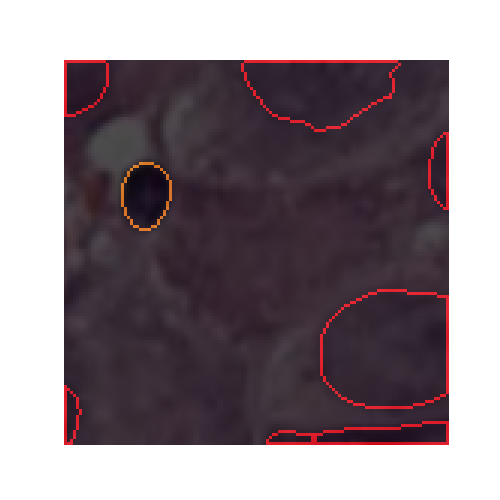

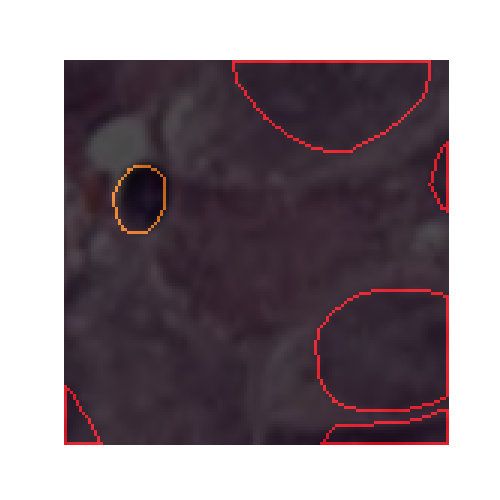

In [71]:

import matplotlib.pyplot as plt
print(ins_gt_1.shape)
instance_segmentation_vizualised(numpy_to_tensor(img_1),ins_1,cell_pred_1,figsize=(5,5))
instance_segmentation_vizualised(numpy_to_tensor(img_1),ins_gt_1,cell_gt_1,figsize=(5,5))